In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Getting data
## Traffic Accident Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
df=pd.read_csv('gdrive/My Drive/crashes.csv')

<ipython-input-2-619539358847>:2: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('gdrive/My Drive/crashes.csv')


## Weather

In [131]:
import json
import requests
import datetime

# Retrieving daily data for max temp, min temp, average temp, and precipitation
def get_weather_data():

  # Generate the range of dates
  start_date = datetime.datetime(2005, 4, 1)
  end_date = datetime.datetime(2023, 9, 30)
  one_day = datetime.timedelta(days=1)
  date_range = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

  # Initialize DataFrame
  weather_df = pd.DataFrame(index=date_range)

  # Codes for max temp, min temp, average temp, and precipitation
  elements = {'max_temp':'1', 'min_temp':'2', 'avg_temp':'43', 'precip':'4'}

  for key, val in elements.items():
    # RCIS API call
    url = "http://data.rcc-acis.org/"
    input_dict = {
        "sid":"USW00023272 6",
        "sdate":"2005-04-01",
        "edate":"2023-09-30",
        "elems":val,
        "output":"json"}
    params = {'params': json.dumps(input_dict)}
    headers = {'Accept': 'application/json'}
    req = requests.post('http://data.rcc-acis.org/StnData', data=params, headers=headers)
    response = req.json()
    response_data = [item[1] for item in response['data']]

    # Store in dataframe
    weather_df[key] = response_data

  return weather_df

In [132]:
weather_df = get_weather_data()
weather_df.head()

,max_temp,min_temp,avg_temp,precip
2005-04-01,69,51,60.0,0.00
2005-04-02,60,50,55.0,0.00
2005-04-03,59,46,52.5,0.61
2005-04-04,60,46,53.0,0.01
2005-04-05,72,47,59.5,0.00


# Imports

# Subsetting data
Dataset includes data over a long period of time. I will check to see if data has been consistently collected over the whole time period and select a period of time to use for this analysis.

If possible, it would be ideal to use only pre-COVID data to help model find predictable trends without the decline in travel from the lockdown affecting the model's accuracy.

In [85]:
# Casting accident year to int
df['accident_year'] = df['accident_year'].astype(int)

In [133]:
df.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,73551,22882000.0,4060000.0,230884432,37.743586,-122.463710,SFPD-INTERIM DB,CITY STREET,12/18/2023 02:15:00 PM,2023 December 18,...,Backing,POINT (-122.46370951 37.743585526),02/16/2024 12:00:00 AM,02/16/2024 12:00:00 AM,02/16/2024 04:12:43 PM,49.0,49.0,10.0,8.0,41.0
1,23055,23838000.0,NaN,150060071,37.781750,-122.396380,SFPD-CROSSROADS,CITY STREET,01/20/2015 10:07:00 AM,2015 January 20,...,Making Right Turn,POINT (-122.396379519 37.781750283),01/20/2015 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,32.0,32.0,1.0,10.0,8.0
2,41755,27803000.0,1977000.0,130332135,37.761830,-122.503878,SFPD-CROSSROADS,CITY STREET,04/23/2013 11:26:00 AM,2013 April 23,...,Parked,POINT (-122.503877741 37.761830418),04/23/2013 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,39.0,39.0,10.0,7.0,35.0
3,24743,30739000.0,8747203.0,3348111,37.783992,-122.408066,SFPD-CROSSROADS,CITY STREET,08/22/2007 10:30:00 PM,2007 August 22,...,NaN,POINT (-122.408066364 37.783992037),08/22/2007 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,19.0,19.0,5.0,10.0,34.0
4,30142,26494000.0,6039101.0,4395868,37.785291,-122.424770,SFPD-CROSSROADS,CITY STREET,09/03/2009 01:35:00 PM,2009 September 03,...,Parked,POINT (-122.424770266 37.785291007),09/03/2009 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,100.0,100.0,4.0,11.0,39.0


accident_year  month    
2005           April        268
               August       258
               December     252
               February     224
               January      245
                           ... 
2023           March        240
               May          218
               November     245
               October      293
               September    271
Length: 228, dtype: int64


<Axes: xlabel='accident_year,month'>

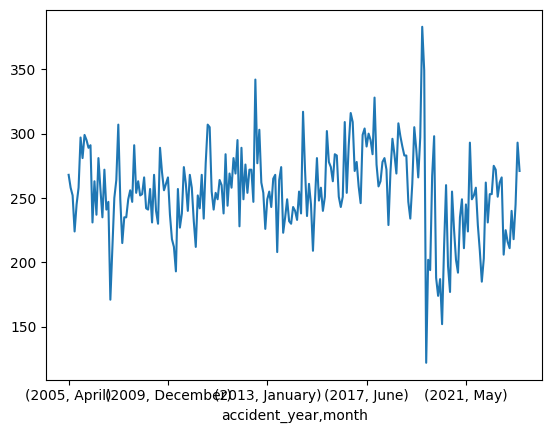

In [5]:
# There is an expected drop in accidents around early 2020
# Most likely due to the pandemic
yearly_counts = df.groupby(by=['accident_year', 'month']).size()
print(yearly_counts)
yearly_counts.plot(kind='line')

In [6]:
selected_dates = df[(df['accident_year'] < 2020) & (df['accident_year'] > 2013)].sort_values(by='collision_datetime')

# Selecting columns

In [7]:
selected_dates.head()

,unique_id,cnn_intrsctn_fkey,cnn_sgmt_fkey,case_id_pkey,tb_latitude,tb_longitude,geocode_source,geocode_location,collision_datetime,collision_date,...,party2_move_pre_acc,point,data_as_of,data_updated_at,data_loaded_at,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
1556,32694,25315000.0,NaN,140000140,37.795945,-122.421768,SFPD-CROSSROADS,CITY STREET,01/01/2014 01:02:00 AM,2014 January 01,...,Proceeding Straight,POINT (-122.421768167 37.795945403),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,105.0,105.0,4.0,3.0,32.0
30178,42787,27519000.0,NaN,140000532,37.772569,-122.484194,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:07:00 AM,2014 January 01,...,Proceeding Straight,POINT (-122.484194201 37.772569062),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,8.0,8.0,8.0,4.0,29.0
18622,15931,30745000.0,8752202.0,140000463,37.777512,-122.416284,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:12:00 AM,2014 January 01,...,NaN,POINT (-122.416284483 37.777512437),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,21.0,21.0,5.0,10.0,34.0
4208,3204,20496000.0,10815000.0,140001944,37.733016,-122.390879,SFPD-CROSSROADS,CITY STREET,01/01/2014 03:59:00 PM,2014 January 01,...,Parked,POINT (-122.390879003 37.733015761),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,86.0,86.0,2.0,9.0,1.0
20670,39694,23377000.0,1814000.0,140002049,37.741691,-122.493868,SFPD-CROSSROADS,CITY STREET,01/01/2014 04:00:00 PM,2014 January 01,...,Parked,POINT (-122.493867758 37.741690713),01/01/2014 12:00:00 AM,04/26/2023 12:00:00 AM,02/16/2024 04:12:43 PM,40.0,40.0,10.0,7.0,35.0


In [8]:
selected_dates.columns

Index(['unique_id', 'cnn_intrsctn_fkey', 'cnn_sgmt_fkey', 'case_id_pkey',
       'tb_latitude', 'tb_longitude', 'geocode_source', 'geocode_location',
       'collision_datetime', 'collision_date', 'collision_time',
       'accident_year', 'month', 'day_of_week', 'time_cat', 'juris',
       'officer_id', 'reporting_district', 'beat_number', 'primary_rd',
       'secondary_rd', 'distance', 'direction', 'weather_1', 'weather_2',
       'collision_severity', 'type_of_collision', 'mviw', 'ped_action',
       'road_surface', 'road_cond_1', 'road_cond_2', 'lighting',
       'control_device', 'intersection', 'vz_pcf_code', 'vz_pcf_group',
       'vz_pcf_description', 'vz_pcf_link', 'number_killed', 'number_injured',
       'street_view', 'dph_col_grp', 'dph_col_grp_description',
       'party_at_fault', 'party1_type', 'party1_dir_of_travel',
       'party1_move_pre_acc', 'party2_type', 'party2_dir_of_travel',
       'party2_move_pre_acc', 'point', 'data_as_of', 'data_updated_at',
       'data_

In [9]:
selected_dates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19575 entries, 1556 to 5475
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   unique_id                     19575 non-null  int64  
 1   cnn_intrsctn_fkey             19575 non-null  float64
 2   cnn_sgmt_fkey                 8003 non-null   float64
 3   case_id_pkey                  19575 non-null  object 
 4   tb_latitude                   19469 non-null  float64
 5   tb_longitude                  19469 non-null  float64
 6   geocode_source                19575 non-null  object 
 7   geocode_location              19575 non-null  object 
 8   collision_datetime            19575 non-null  object 
 9   collision_date                19575 non-null  object 
 10  collision_time                19540 non-null  object 
 11  accident_year                 19575 non-null  int64  
 12  month                         19575 non-null  object 
 13  day_

# map

In [10]:
mean_lat = selected_dates['tb_latitude'].mean()
mean_long = selected_dates['tb_longitude'].mean()

In [11]:
selected_dates['tb_latitude'].describe()


count    19469.000000
mean        37.766058
std          0.024488
min         37.707459
25%         37.749391
50%         37.772624
75%         37.783991
max         37.829991
Name: tb_latitude, dtype: float64

In [12]:
selected_dates['tb_longitude'].describe()


count    19469.000000
mean      -122.427714
std          0.028412
min       -122.513615
25%       -122.441020
50%       -122.420705
75%       -122.407534
max       -122.363288
Name: tb_longitude, dtype: float64

All possible latitude and longitude values within the city limits should fit in this area. I'll encode the accidents by assigning them to a cell in a square matrix that covers this area.

In [13]:
import folium
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)
folium.Marker(
    location = [37.71, -122.53]
).add_to(m)
folium.Marker(
    location = [37.84, -122.34]
).add_to(m)
folium.Marker(
    location = [37.84, -122.53]
).add_to(m)
folium.Marker(
    location = [37.71, -122.34]
).add_to(m)
m

In [14]:
import numpy as np

# min and max values where all accidents should be within
max_lat = 37.84
min_lat = 37.70
max_long = -122.35
min_long = -122.52

# generate 31 equally spaced points within the latitude and longitude ranges (30x30 grid)
lat_values = np.linspace(min_lat, max_lat, 31)
long_values = np.linspace(min_long, max_long, 31)

# center map
mean_lat = np.mean(lat_values)
mean_long = np.mean(long_values)
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# horizontal grid lines
for lat in lat_values:
    polyline = [(lat, min_long), (lat, max_long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m)

# vertical grid lines
for long in long_values:
    polyline = [(min_lat, long), (max_lat, long)]
    folium.PolyLine(locations=polyline, color='blue', weight = 0.5).add_to(m)

m

In [15]:
grid_boundaries = []

# Iterate through latitude values
for i in range(len(lat_values) - 1):
    lat1, lat2 = lat_values[i], lat_values[i + 1]
    # Iterate through longitude values
    for j in range(len(long_values) - 1):
        long1, long2 = long_values[j], long_values[j + 1]
        # Define the boundaries of the grid area
        boundary = [(lat1, long1), (lat1, long2), (lat2, long2), (lat2, long1), (lat1, long1)]
        # Append the boundary to the list
        grid_boundaries.append(boundary)

# Display the list of boundaries
for idx, boundary in enumerate(grid_boundaries):
    print(f"Grid Area {idx + 1}: {boundary}")

Grid Area 1: [(37.7, -122.52), (37.7, -122.51433333333333), (37.70466666666667, -122.51433333333333), (37.70466666666667, -122.52), (37.7, -122.52)]
Grid Area 2: [(37.7, -122.51433333333333), (37.7, -122.50866666666666), (37.70466666666667, -122.50866666666666), (37.70466666666667, -122.51433333333333), (37.7, -122.51433333333333)]
Grid Area 3: [(37.7, -122.50866666666666), (37.7, -122.503), (37.70466666666667, -122.503), (37.70466666666667, -122.50866666666666), (37.7, -122.50866666666666)]
Grid Area 4: [(37.7, -122.503), (37.7, -122.49733333333333), (37.70466666666667, -122.49733333333333), (37.70466666666667, -122.503), (37.7, -122.503)]
Grid Area 5: [(37.7, -122.49733333333333), (37.7, -122.49166666666666), (37.70466666666667, -122.49166666666666), (37.70466666666667, -122.49733333333333), (37.7, -122.49733333333333)]
Grid Area 6: [(37.7, -122.49166666666666), (37.7, -122.48599999999999), (37.70466666666667, -122.48599999999999), (37.70466666666667, -122.49166666666666), (37.7, -12

In [16]:
selected_dates.dropna(subset = ['tb_latitude', 'tb_longitude'], inplace=True)


Grid Area 692: [(37.80733333333334, -122.51433333333333), (37.80733333333334, -122.50866666666666), (37.812000000000005, -122.50866666666666), (37.812000000000005, -122.51433333333333), (37.80733333333334, -122.51433333333333)]
Grid Area 693: [(37.80733333333334, -122.50866666666666), (37.80733333333334, -122.503), (37.812000000000005, -122.503), (37.812000000000005, -122.50866666666666), (37.80733333333334, -122.50866666666666)]
Grid Area 694: [(37.80733333333334, -122.503), (37.80733333333334, -122.49733333333333), (37.812000000000005, -122.49733333333333), (37.812000000000005, -122.503), (37.80733333333334, -122.503)]
Grid Area 695: [(37.80733333333334, -122.49733333333333), (37.80733333333334, -122.49166666666666), (37.812000000000005, -122.49166666666666), (37.812000000000005, -122.49733333333333), (37.80733333333334, -122.49733333333333)]
Grid Area 696: [(37.80733333333334, -122.49166666666666), (37.80733333333334, -122.48599999999999), (37.812000000000005, -122.48599999999999),

In [17]:
def preprocess_crashes(selected_dates)
# Create a dictionary to store the matrices for each date
date_matrices = {}

# Group the dataframe by 'collision_date'
grouped_dates = selected_dates.groupby('collision_date')

# Iterate through each date group
for date, group in grouped_dates:
    # Create a 30x30 matrix initialized with zeros
    matrix = np.zeros((30, 30), dtype=int)

    # Iterate through each row in the group
    for index, row in group.iterrows():
        # Compute the indices for the matrix
        lat_index = int((row['tb_latitude'] - min_lat) / (max_lat - min_lat) * 30)
        long_index = int((row['tb_longitude'] - min_long) / (max_long - min_long) * 30)

        # Increment the corresponding cell in the matrix
        matrix[lat_index, long_index] += 1

    # Store the matrix in the dictionary with the date as the key
    date_matrices[date] = matrix


# Check if daily accident sums are equal
daily_count = grouped_dates.size().to_list()
matrices_sum = []
for key in date_matrices.keys():
  matrices_sum.append(sum(sum(date_matrices[key])))
daily_count == matrices_sum

True

In [18]:
# Check if daily accident sums are equal
daily_count = grouped_dates.size().to_list()
matrices_sum = []
for key in date_matrices.keys():
  matrices_sum.append(sum(sum(date_matrices[key])))
daily_count == matrices_sum

True

# Make input suitable for LSTM

In [19]:
# Prepare input matrices
dates = list(date_matrices.keys())
matrices = [date_matrices[date] for date in dates]
input_matrices = np.array(matrices)

# Prepare target matrices
# Shift the matrices by one time step for sequence prediction
target_matrices = np.roll(input_matrices, -1, axis=0)

In [20]:
# Extract day of week and month
days_of_week = [datetime.strptime(date, '%Y %B %d').weekday() for date in dates]  # 0: Monday, 1: Tuesday, ..., 6: Sunday
months = [datetime.strptime(date, '%Y %B %d').month for date in dates]  # 1: January, 2: February, ..., 12: December

from sklearn.preprocessing import OneHotEncoder

# Convert the list of days_of_week and months to np arrays
days_of_week_array = np.array(days_of_week)
months_array = np.array(months)

# Reshape the arrays to be column vectors
days_of_week_array = days_of_week_array.reshape(-1, 1)
months_array = months_array.reshape(-1, 1)

# Create OneHotEncoder instances for day of the week and month separately
encoder_day_of_week = OneHotEncoder(categories='auto', sparse_output=False)
encoder_month = OneHotEncoder(categories='auto', sparse_output=False)

# Fit and transform the data for day of the week
encoded_days_of_week = encoder_day_of_week.fit_transform(days_of_week_array)

# Fit and transform the data for month
encoded_months = encoder_month.fit_transform(months_array)

# Train validation test split

In [65]:
from sklearn.model_selection import train_test_split
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(input_matrices, target_matrices, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define model
Defining two models, one that includes the weather data and one that does not. I will compare the performance of the two.

In [3]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, concatenate, Reshape, Flatten

In [4]:
# Input shapes
input_shape_matrices = (30, 30)
input_shape_day_of_week = (7,)
input_shape_month = (12,)

# Define input layers
input_matrices_layer = Input(shape=input_shape_matrices)
input_day_of_week = Input(shape=input_shape_day_of_week)
input_month = Input(shape=input_shape_month)

# Concatenate the day of week and month inputs
concatenated_inputs = concatenate([input_day_of_week, input_month])

# Reshape concatenated input to include the timestep dimension
reshaped_inputs = Reshape((1, -1))(concatenated_inputs)

# Define LSTM layer for processing the concatenated input
lstm_out = LSTM(units=64)(reshaped_inputs)

# Flatten the matrix input
flattened_matrices = Flatten()(input_matrices_layer)

# Concatenate LSTM output with the flattened matrix input
concatenated_outputs = concatenate([lstm_out, flattened_matrices])

# Define output layer
output = Dense(units=30*30, activation='linear')(concatenated_outputs)  # Output is a matrix

# Reshape output to match the shape of the input matrix
output = Reshape((30, 30))(output)

# Define the model
model = Model(inputs=[input_matrices_layer, input_day_of_week, input_month], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 19)                   0         ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 1, 19)                0         ['concatenate[0][0]']     

In [24]:
# Fit model
history = model.fit(
    [X_train, encoded_days_of_week[:len(X_train)], encoded_months[:len(X_train)]],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_val, encoded_days_of_week[len(X_train):len(X_train)+len(X_val)], encoded_months[len(X_train):len(X_train)+len(X_val)]], y_val)
)

Epoch 1/50
48/48 [==============================] - 4s 30ms/step - loss: 0.0170 - mae: 0.0751 - val_loss: 0.0150 - val_mae: 0.0647
Epoch 2/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0122 - mae: 0.0522 - val_loss: 0.0129 - val_mae: 0.0504
Epoch 3/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0104 - mae: 0.0403 - val_loss: 0.0121 - val_mae: 0.0429
Epoch 4/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0095 - mae: 0.0343 - val_loss: 0.0118 - val_mae: 0.0388
Epoch 5/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0090 - mae: 0.0310 - val_loss: 0.0117 - val_mae: 0.0364
Epoch 6/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0087 - mae: 0.0291 - val_loss: 0.0116 - val_mae: 0.0350
Epoch 7/50
48/48 [==============================] - 1s 22ms/step - loss: 0.0085 - mae: 0.0281 - val_loss: 0.0117 - val_mae: 0.0342
Epoch 8/50
48/48 [==============================] - 1s 24ms/step - loss: 0.0083 - m

In [ ]:
# Define input layers
input_weather = Input(shape=input_shape_matrices)

# Concatenate the day of week, month, and temp/precip inputs
concatenated_inputs_weather = concatenate([input_day_of_week, input_month, input_weather])

# Reshape concatenated input to include the timestep dimension
reshaped_inputs_weather = Reshape((1, -1))(concatenated_inputs)

# Define LSTM layer for processing the concatenated input
lstm_out_weather = LSTM(units=64)(reshaped_inputs)

# Flatten the matrix input
flattened_matrices_weather = Flatten()(input_matrices_layer)

# Concatenate LSTM output with the flattened matrix input
concatenated_outputs_weather = concatenate([lstm_out_weather, flattened_matrices_weather])

# Define output layer
output = Dense(units=30*30, activation='linear')(concatenated_outputs_weather)  # Output is a matrix

# Reshape output to match the shape of the input matrix
output = Reshape((30, 30))(output)

# Define the model
model_weather = Model(inputs=[input_matrices_layer, input_day_of_week, input_month, input_weather], outputs=output)

# Compile the model
model_weather.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
model.summary()

In [66]:
predictions = model.predict([X_test, encoded_days_of_week[len(X_train) + len(X_val):], encoded_months[len(X_train) + len(X_val):]])

11/11 [==============================] - 0s 4ms/step


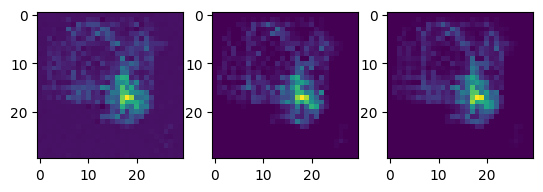

In [134]:
pred_sum = np.sum(predictions, axis=0)
actual_sum = np.sum(y_test, axis=0)
train_sum = np.sum(input_matrices, axis=0)
plt.subplot(1, 3, 1)
plt.imshow(pred_sum)

plt.subplot(1, 3, 2)
plt.imshow(actual_sum)

plt.subplot(1, 3, 3)
plt.imshow(train_sum)

In [67]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
mae

ValueError: Found array with dim 3. None expected <= 2.

# Evaluating performance of the model
Problem: How to evaluate the performance of a neural network that outputs a 30x30 matrix?
MSE and MAE are only considering the values in the matrix, not the location of the values.

## Potential approach:
- Comparing monthly estimates to actual monthly outcomes.
- Sum all of the matrices for predicted month and actual month.
- Convert summed matrices to 30x30 image.
- Calculate the structural similarity index between the actual and predicted images.

In [25]:
import numpy as np

In [59]:
m1 = input_matrices[0]
m2 = input_matrices[20]
m3 = input_matrices[0]
for i in input_matrices[1:31]:
  m3 += i

In [60]:
print("m1")
print(m1)
print("\nm2")
print(m2)
print()
print(m3)

m1
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 2 2 0 0 0 0 0 0 0 0 3 2 1 2 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 2 1 0 0 0 0 1 3 1 1 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 3 0 5 1 4 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 1 0 1 1 2 4 1 1 5 1 1 1 1 0 1 0 

In [57]:
from skimage.metrics import structural_similarity as ssim

def compare_matrices_ssim(matrix1, matrix2):
    """
    Compare the similarity between two matrices using Structural Similarity Index (SSIM).

    Parameters:
        matrix1 (numpy.ndarray): First matrix.
        matrix2 (numpy.ndarray): Second matrix.

    Returns:
        float: Structural Similarity Index (SSIM) between the two matrices.
    """
    return ssim(matrix1, matrix2)

ssim_value = compare_matrices_ssim(m1, m2)
ssim_value

1.0

Text(0.5, 1.0, 'Matrix 2')

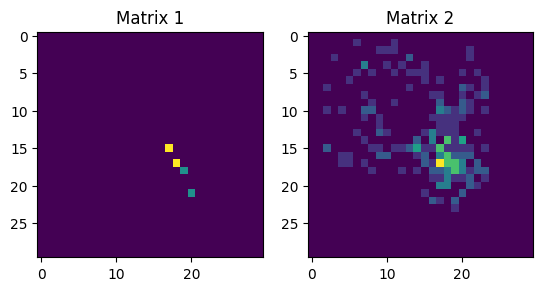

In [62]:
import skimage
skimage.data.camera()
import numpy as np
from matplotlib import pyplot as plt


plt.subplot(1, 2, 1)
plt.imshow(m1)
plt.subplot(1, 2, 2)
plt.imshow(m3)
plt.title('Matrix 2')



In [143]:
from folium import plugins

# Define the boundaries of the image overlay
overlay_bounds = [(min_lat, min_long), (max_lat, max_long)]

# Create the Folium map
m = folium.Map(location=(mean_lat, mean_long), zoom_start=12)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image=np.array(m3),  # Convert m1 to numpy array
    bounds=overlay_bounds,
    opacity=0.5,
).add_to(m)
m

In [136]:
! pip install folium[plugins]
